# Dia 3 - Parte 1

## Exercício 3 (Árvore de Decisão)

Usando o seguinte banco de dados usar o algortimo de árvore de decisão para descobrir classes de animes.

In [ ]:
# Importando os dados
import pandas as pd
import random
from sklearn.tree import DecisionTreeClassifier
animes = pd.read_csv("animes.csv", ";")
animes.head()

# genres: mecha, music, historical

# Vamos definir 3 classes: 
# -> 0: animes bons
# -> 1: animes médianos
# -> 2: animes ruins 

class_ = []
for id_, row in animes.iterrows():
    if random.randint(0, 10) < 9:
        rating = row['rating']
        if rating > 7:
            class_.append(0)
        elif rating <= 7 and rating > 5:
            class_.append(1)
        else:
            class_.append(2)
    else: # Vamos adicionar algum ruído
        class_.append(random.randint(0, 2))
animes["class"] = class_
animes.head()

In [ ]:
animes_features = animes.drop(["id", "name", "class", "source", "type"], axis = 1)
animes_features.head()

In [ ]:
animes_target = animes["class"]
animes_target.head()

In [ ]:
from sklearn.model_selection import train_test_split

a_features_train, a_features_test, a_target_train, a_target_test = train_test_split(
    animes_features, animes_target, test_size = 0.2, random_state = 35)

clf = DecisionTreeClassifier().fit(a_features_train, a_target_train)
# OU:
# clf = DecisionTreeClassifier()
# clf.fit(a_features_train, a_target_train)

decision_tree_pred = clf.predict(a_features_test)
print(decision_tree_pred)

## Exercício 4 (SVM)

Use a mesma base com animes para fazer classificação dos animes, agora usando o SVM.

In [ ]:
# Feito pelo aluno
# Importando os dados
import pandas as pd
import random
from sklearn import svm

clf = svm.LinearSVC(C = 1.0)
clf.fit(a_features_train, a_target_train)
linear_svm_pred = clf.predict(a_features_test)
print(linear_svm_pred)

## Medidas de Desempenho

**Documentação:**<br>
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html<br>
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html<br>
http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html<br>
http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html<br>
http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter<br>


Agora vamos usar os dados gerados nos exercícios 3 e 4 (usando a base de dados dos animes) e comparar o desempenho dos dois algoritmos usando a acurácia de teste. Qual deles teve um desempenho melhor?

In [ ]:
# importamos a função para calcular a acurácia
from sklearn.metrics import accuracy_score

# e passamos para ela os alvos de teste e as previsões do nosso modelo
print(accuracy_score(a_target_test, decision_tree_pred))
print(accuracy_score(a_target_test, linear_svm_pred))

Também podemos simultaneamente predizer e calcular a acurácia com a função "score" de objetos de classificação do scikit-learn. Por exemplo, vamos usar novamente a base de dados Íris com o KNN:

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

iris = load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Passamos agora o conjunto de dados de teste, 
# separados por atributos e alvos, e obtemos a acurácia
print(knn.score(X_test, y_test))

# Em vez de
#pred = knn.predict(X_test)
#print(accuracy_score(y_test, pred))

Agora tente executar o código acima algumas vezes. Obervamos que uma das desvantagens do train_test_split é sua alta variância: dependendo de quais linhas são reservadas para treino e quais para teste, obtemos resultados diferentes.
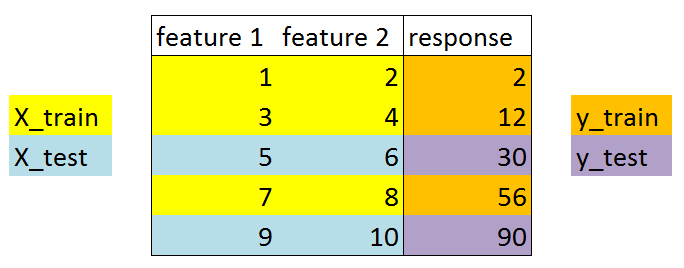

Isso pode ser resolvido com o uso de *cross_val_score*, uma função de validação que calcula alguma métrica da sua escolha baseado num algoritmo de *K-fold cross-validation*: os dados são divididos num número cv de subconjuntos (ou *folds*), daí entramos num laço - na primeira iteração, o primeiro fold é usado como teste, enquanto os outros são usadas para treino, na segunda o segundo será reservado para treino, e assim por diante.<br>
Isso nos dará um valor de acurácia para cada uma das cv iterações, a média das quais nos dará uma métrica mais confiável do comportamento do nosso modelo, como veremos abaixo.
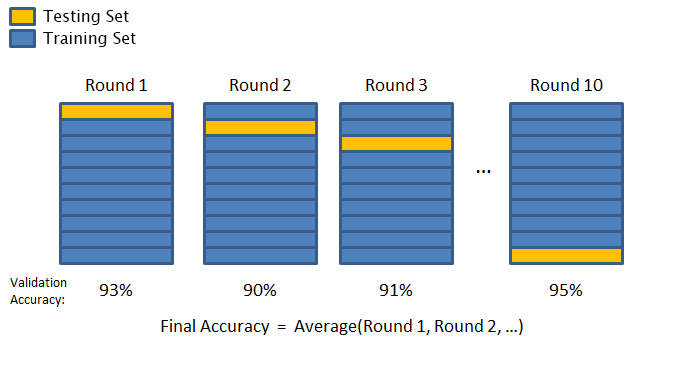

In [ ]:
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
print(scores)
print(scores.mean())

Com essa métrica em mãos, vamos tentar determinar qual número k de vizinhos nos dá os melhores resultados para esse problema.

In [ ]:
import matplotlib.pyplot as plt

# Criamos uma lista com todos os valores de 1 a 29 (inclusivo)
k_opt = list(range(1, 30))
scores = []
# Para cada valor de k, adicionamos sua acurácia média a uma lista
for k in k_opt:
    knn = KNeighborsClassifier(n_neighbors=k)    
    score = cross_val_score(knn, X, y, cv=10, scoring='accuracy').mean()
    scores.append(score)

# e visualizamos
plt.plot(k_opt, scores)
plt.xlabel('Número K de vizinhos')
plt.ylabel('Acurácia média')
plt.show()

Que conclusões podem ser tiradas desse gráfico? Qual sua relação com os conceitos de *underfitting* e *overfitting*?

Agora, note que se quisermos tentar variar também outros hiperparâmetros, teremos que inserí-los como laços aninhados, o que pode deixar nosso código mais extenso e menos legível. Por esse e outros motivos, apresentaremos outra classe bastante útil, *GridSearchCV*, que consiste basicamente de uma matriz multidimensional contendo todas as combinações de parâmetros especificadas, e irá testar todas com o método de aprendizagem especifiado e os dados do seu problema, gerando medidas de desempenho para cada uma.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Vamos testar novamenente todos esses valores de k
k_opt = list(range(1, 30))
# Mas variando também a opção 'weights', que nos diz se devemos considerar
# a distância dos k vizinhos mais próximos como pesos numa média ponderada ou não
weight_opt = ['uniform', 'distance']

# inserimos essas opções num dicionário com o seguinte formato
param_grid = {
    'n_neighbors': k_opt, 
    'weights': weight_opt
}
print(param_grid)

In [ ]:
# Instanciamos nosso estimador (os parâmetros não importam)
knn = KNeighborsClassifier()

# Criamos o GridSearchCV, passando ao menos 
# o estimador e o dicionário de parâmetros
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')

# Agora passamos nossos dados, e aqui ocorre todo
# e treinamento e teste da grid
grid.fit(X, y)

# Podemos então obter uma configuração de
# parâmetros que obteve score ótimo:
print(grid.best_params_)

Mas vamos ver como se saíram todas as combinações de parâmetros testadas.

In [ ]:
# Aqui obtemos uma lista dos scores médios (no caso, acurácia)
scores = grid.cv_results_['mean_test_score']
# E aqui uma lista correspondente de combinações de parâmetros
param_combinations = grid.cv_results_['params']

# Vamos separar aqui os scores com pesos uniformes e
# com pesos por distância, para plotá-los separadamente
uniform_scores = []
distance_scores = []
for score, params in zip(scores, param_combinations):
    if (params['weights'] == 'uniform'):
        uniform_scores.append(score)
    else:
        distance_scores.append(score)


plt.plot(k_opt, uniform_scores, 'b', label='pesos uniformes')
plt.plot(k_opt, distance_scores, 'r', label='pesos por distância')
plt.xlabel('Número K de vizinhos')
plt.ylabel('Acurácia média')
plt.legend()
plt.show()

### Exercício 5
Vamos tomar agora um exemplo de regressão, onde temos valores investidos em publicidade em TV, rádio, e jornais, e queremos estimar o número de vendas resultantes dessas propagandas.

In [ ]:
# Carregando os dados diretamente uma URL, especificando a coluna de índices
data = pd.read_csv('http://www-bcf.usc.edu/~gareth/ISL/Advertising.csv', index_col=0)

# Visualizando parte da tabela de dados
print(data.shape)
print(data.head())
print(data.tail())

# Separando dados em atributos e alvos
atributos = ['TV', 'Radio', 'Newspaper']
X = data[atributos]
y = data['Sales']

Tente aplicar alguns dos métodos vistos até agora, e analizar quais deles tem uma melhor performance, e com que hiperparâmetros. Como estamos lidando com um problema de regressão, tente usar metrics.mean_squared_error ou mudar o parâmetro *scoring* de cross_val_score ou GridSearchCV para "neg_mean_squared_error". Se lembre de verificar a documentação em caso de dúvidas. Mesmo que você não entenda muito, uma busca cuidadosa pode revelar o que você procura.